Author: Markus Kongstein Rognlien (NTNU)

Supervisor: Nicolas Mounet (ABP-CEI)

In [1]:
from pywit.utilities import create_resonator_component, create_resonator_element
from pywit.plot import plot_component_impedance, plot_component_wake, generate_contribution_plots, plot_total_impedance_and_wake
from pywit.interface import import_data_iw2d, create_component_from_data, create_iw2d_input_from_yaml, create_element_using_iw2d, create_multiple_elements_using_iw2d
from pywit.element import Element
from pywit.model import Model
import numpy as np

# PyWIT Demonstration
### Python Wake and Impedance Toolbox

## Components
The most fundamental object of PyWIT is the component. It contains the wake and/or the impedance function in a specific combination of test/source exponents, caused by one object. There are several ways to initialize components. In fact, the impedance and wake functions as well as the other parameters of the component can be completely arbitrarily defined. Somewhat more useful, perhaps, are utility functions for creating things like resonator components. A resonator component uses a selection of the following formulas, depending on what plane it is in.

![title](img/resonator_formulae.png)

In order to create a dipolar resonator component in the x-plane, we simply call `create_resonator_component` with the appropriate arguments. Naturally, this requires us to specify a shunt impedance, a quality factor and a resonance frequency.

In [2]:
shunt_impedance = 2.3355e5
quality_factor = 1.4866
resonance_frequency = 4.6683e9

In order to specify that our component is a dipolar component in the x-plane, we first specify that the plane is `'x'`. The rest is conveyed by the `exponents` argument. These correspond to the x and y exponents for the source and test particles, also known as (a, b, c, d). For the case of a dipolar component in the x-plane, these are given by (1, 0, 0, 0).

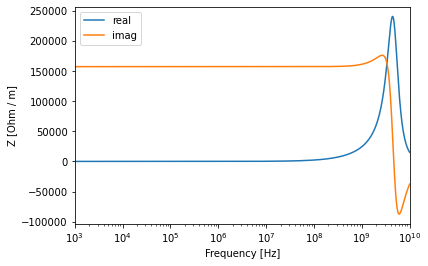

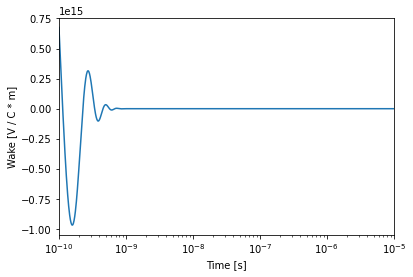

In [3]:
resonator_component_1 = create_resonator_component(plane='x',
                                                exponents=(1, 0, 0, 0),
                                                r=shunt_impedance,
                                                q=quality_factor,
                                                f_r=resonance_frequency)

plot_component_impedance(resonator_component_1, logscale_y=False)
plot_component_wake(resonator_component_1, logscale_y=False, stop=1e-5)

We can also give our component a name and get some basic information about it by printing it.

In [4]:
resonator_component_1.name = 'Resonator Component'
print(resonator_component_1)

Resonator Component with parameters:
Plane:			x
Source exponents:	1, 0
Test exponents:		0, 0
Impedance function:	DEFINED
Wake function:		DEFINED
Impedance-regions of interest: (3098173536.929907, 6238426463.070093)
Wake-regions of interest: 


An effort has been made during the development of PyWIT to allow for any combination of exponents. Though not thoroughly tested, it should be possible to model non-linear components simply by specifying their source and test exponents.

The point of modelling components this way should hopefully become more clear when observing their behaviour in combination with other components. Let's make two more resonators which are identical to our first resonator in almost every way. One of them is a dipolar component in the y-plane, and the other one is still in the x-plane but has a slightly different resonance frequency.

In [5]:
resonator_component_y =  create_resonator_component(plane='y',
                                                    exponents=(0, 1, 0, 0),
                                                    r=shunt_impedance,
                                                    q=quality_factor,
                                                    f_r=resonance_frequency)

resonator_component_2 = create_resonator_component(plane='x',
                                                exponents=(1, 0, 0, 0),
                                                r=shunt_impedance,
                                                q=quality_factor,
                                                f_r=resonance_frequency / 100)

One fundamental property of PyWIT, which the rest of the tool is in many ways built on, is the ability to add components together. There are, however, strict restrictions on which components can be added together. It is not possible to add together two components which have differing exponents or are in different planes. Let's verify this by attempting to add our dipolar x-component and y-component.

In [6]:
invalid_component = resonator_component_1 + resonator_component_y

AssertionError: The two addends correspond to different planes and cannot be added.
x != y

Expectedly, the addition failed, giving the error message "The two addends correspond to different planes and cannot be added. x != y". The third resonator we defined, however, is compatible for addition with the first as they are both in the same plane and have the same exponents. Let's add them together and plot the resulting components.

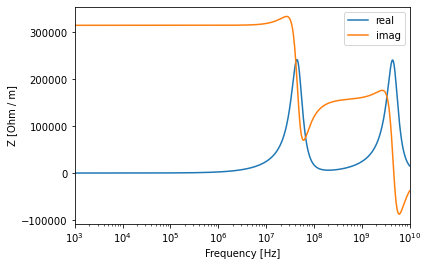

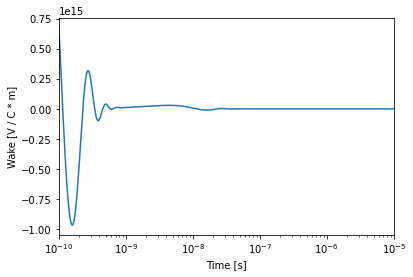

In [7]:
component_sum = resonator_component_1 + resonator_component_2
plot_component_impedance(component_sum, logscale_y=False)
plot_component_wake(component_sum, logscale_y=False, stop=1e-5)

A list of components can also be added together using the `sum()`function.

## Elements
If we move "up" one layer, we find the Element class. Elements are essentially a collection of components which together define the full impedance and wake properties of a physical device. In order to accurately do this, each element has to be defined with an associated beta function value in the x and y direction. They also need to have a specified length. As with components, there are numerous ways to define elements, including the completely custom class inititialition functions, but we will focus on two of the most useful, namely resonators and resistive walls.

Let's first try to create a resonator element using the `create_resonator_element`function. Doing this requires a bit of work, we need to create dictionaries with the parameters corresponding to each component we want our element to contain. So let's do this for an element with 4 components. The keys of the dictionary are given by the plane we want the component to occupy, followed by the four exponents of that component.

In [8]:
shunt_impedances = {'x1000': 2.33552570e+05,
                    'y0100': 5.74693614e+05,
                    'x0010': 2.56807799e+05,
                    'y0001': 2.56807799e+05}

quality_factors = {'x1000': 1.48667264e+00,
                   'y0100': 1.55128828e+00,
                   'x0010': 2.00000000e+00,
                   'y0001': 1.93734957e+00}

resonance_frequencies = {'x1000': 4.66833640e+09,
                         'y0100': 4.11886764e+09,
                         'x0010': 4.47397140e+09,
                         'y0001': 4.57954054e+09}

Now we can pass these dictionaries along with a length and the beta functions to the function `create_resonator_element`, which should return an element describing our resonator. And just like for components, we can give it a name and display some basic information by printing it.

In [9]:
resonator_element = create_resonator_element(1, 17, 17, shunt_impedances, quality_factors, resonance_frequencies)

resonator_element.name = "Resonator Element"
print(resonator_element)

Resonator Element with parameters:
Length:		1
Beta_x:		17
Beta_y:		17
#components:	4


A large portion of development time on PyWIT has been spent on implementing interfacing functions with IW2D. This makes the process of creating resistive wall elements in PyWIT much easier. There are multiple ways to interface with IW2D to create elements.

If we already have IW2D data files, we can import them into PyWIT as "component recipes", make components out of those recipes, and subsequently make elements with those components. This method is slightly convoluted, but is our best option if we don't want to perform any new computations.

In [10]:
recipes1 = import_data_iw2d('/home/markus/PS_data/IW2D', '_PS_InconelX750_round_HG35.0mm_precise')
recipes2 = import_data_iw2d('/home/markus/PS_data/IW2D', '_PS_ss316LN_round_HG35.0mm_precise')
components1 = [create_component_from_data(*recipe, relativistic_gamma=27.7513022027) for recipe in recipes1]
components2 = [create_component_from_data(*recipe, relativistic_gamma=27.7513022027) for recipe in recipes2]
resistive_wall1 = Element(1, 17.00884579219969, 16.83582453350477, components1)
resistive_wall2 = Element(1, 17.00884579219969, 16.83582453350477, components2)

print(resistive_wall1)
print()
print(resistive_wall2)

Unnamed Element with parameters:
Length:		1
Beta_x:		17.00884579219969
Beta_y:		16.83582453350477
#components:	5

Unnamed Element with parameters:
Length:		1
Beta_x:		17.00884579219969
Beta_y:		16.83582453350477
#components:	5


Alternatively, if we want to create a completely new element, using IW2D to do the heavy lifting, we can use the function `create_element_using_iw2d`. This function takes an `IW2DInput` object as a parameter, which is analogous to the input-files used with IW2D. These can be defined in "iw2d_inputs.yaml" which is created upon installation of PyWIT. Let's place the following entry in that file:

```
test_input_1:
  machine: LHC
  length: 1
  relativistic_gamma: 479.605064966
  calculate_wake: False
  comment: _test_coll_round
  f_params:
    start: 1e3
    stop: 1e13
    scan_type: 2
    sampling_exponent: 1e8
    points_per_decade: 1000
    min_refine: 1e11
    max_refine: 5e12
    n_refine: 50
    added:
  is_round: True
  yokoya_factors: 1 1 1 0 0
  layers:
    -
      distance_to_center: 2
      dc_resistivity: 5e-6
      resistivity_relaxation_time: 4.2
      re_dielectric_constant: 1
      magnetic_susceptibility: 0
      permeability_relaxation_frequency: inf
```

By referring to the name of this entry in iw2d_inputs.yaml, we can construct an `IW2DInput` object by using `create_iw2d_input_from_yaml`.

In [11]:
iw2d_input = create_iw2d_input_from_yaml('test_input_1')

This input-object can be passed to `create_element_using_iw2d` along with a name and the beta functions to create a fully-fledged resistive wall element.

In [12]:
resistive_wall = create_element_using_iw2d(iw2d_input, 'resistive_wall', 17, 17)

print()
print(resistive_wall)


resistive_wall with parameters:
Length:		1.0
Beta_x:		17
Beta_y:		17
#components:	5


This function took some time to finish, as it involved converting the `IW2DInput` object into a classic IW2D input textfile, passing that to the correct binary IW2D executable through the terminal, waiting for the results, and subsequently importing the data and structuring it into a PyWIT element.

If you wanted to use this element again another time, it would be nice if PyWIT remembered the results of the computation, so that it would not have to be performed again. This is precisely why every `IW2DInput` object is cached. If we want to generate this element again, PyWIT will recognize that the computation has already been performed and construct the element from the data instantly.

In [13]:
resistive_wall = create_element_using_iw2d(iw2d_input, 'resistive_wall', 17, 17)

print()
print(resistive_wall)

The computation of 'resistive_wall' has already been performed with the exact given parameters. These results will be used to generate the element.

resistive_wall with parameters:
Length:		1.0
Beta_x:		17
Beta_y:		17
#components:	5


The element does not have to have the same name for the caching to work, as it is the anticipated result of the computation which is the determining factor.

In [14]:
resistive_wall = create_element_using_iw2d(iw2d_input, 'completely_different_wall', 17, 17)

print()
print(resistive_wall)

Another element, 'resistive_wall', has previously been computed with the exact same parameters as 'completely_different_wall'. Do you wish to re-perform the computation, or construct an element from the already computed values?
1: Re-do computation
2: Use old values (recommended)
Your choice: 2

resistive_wall with parameters:
Length:		1.0
Beta_x:		17
Beta_y:		17
#components:	5


Furthermore, we can utilize multithreading to speed up the computation itself. IW2D's computations themselves are single-threaded, but if we want to generate multiple elements using IW2D, we can save time by performing this computation in parallel. Let's place some more elements in iw2d_inputs.yaml, in this demonstration on the form "test_input_n" for "n" going from 1 to 9.

In [15]:
# Generates the list of names
names = [f'test_input_{n}' for n in range(1, 10)]

# Generates the corresponding IW2DInput objects
iw2d_inputs = [create_iw2d_input_from_yaml(name) for name in names]

# For simplicity, using beta_x = beta_y = 17 for all elements
beta_xs = [17 for _ in range(9)]
beta_ys = [17 for _ in range(9)]

elements = create_multiple_elements_using_iw2d(iw2d_inputs, names, beta_xs, beta_ys)

Another element, 'resistive_wall', has previously been computed with the exact same parameters as 'test_input_1'. These computed values will be re-used to construct the new element.
Running IW2D computation for test_input_2
Running IW2D computation for test_input_3
Running IW2D computation for test_input_4
Running IW2D computation for test_input_5
Running IW2D computation for test_input_6
Running IW2D computation for test_input_7
Running IW2D computation for test_input_8
Running IW2D computation for test_input_9
Element resistive_wall completed
Element test_input_3 completed
Element test_input_7 completed
Element test_input_5 completed
Element test_input_4 completed
Element test_input_6 completedElement test_input_8 completed

Element test_input_2 completedElement test_input_9 completed



The Element class is by far the most complex out of the three layers, and has a number of useful functions associated with it. Without spending too much time demonstrating all of them, below is a non-exhaustive list along with a short explanation for each function.

In [16]:
# Constructs a new element which is a copy of another element, rotated by a user-specified angle
rotated_element = resistive_wall.rotated(np.pi / 2)

# Elements can be added together, creating a new element representing the sum of their effects
sum_of_two_elements = resistive_wall + resonator_element

# One can also utilize the sum()-notation to accomplish the same addition for multiple elements
sum_of_many_elements = sum(elements)

# Creates a new element which is a copy of another element, but which has had its beta_x and beta_y attributes
# changed, as well as the impedance and wake functions of its elements scaled, to simulate the effect of moving
# the element to a location in the loop with a different beta-function.
moved_element = resonator_element.changed_betas(16, 16)

# Multiplying an element by a scalar scales the wake and impedance functions of its components accordingly
scaled_element = 4.2 * resistive_wall

## Model
Finally, at the top layer, we have the model class. Analogous to the way Elements are a collection of components, a Model is a collection of Elements. The model class is useful when considering a collection of elements as a single, potentially lumped, impedance. When a model has been constructed, it can be passed as an argument to a number of different plotting functions.

Let's take the 9 resistive wall elements we constructed using IW2D in the previous section. If we apply different tags to them, we can pass a model containing them to the function `generate_contribution_plots` which groups elements by their tags and plots their contribution to the total impedance (and wake) in each component.

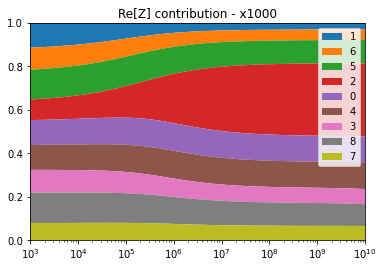

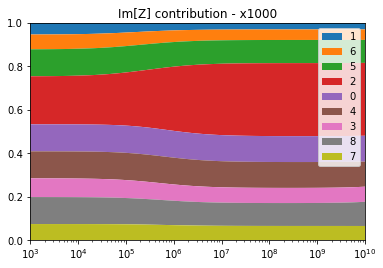

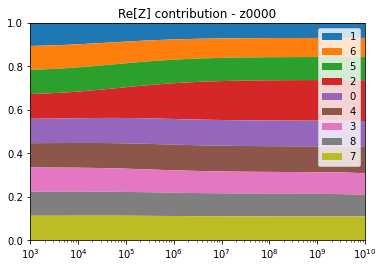

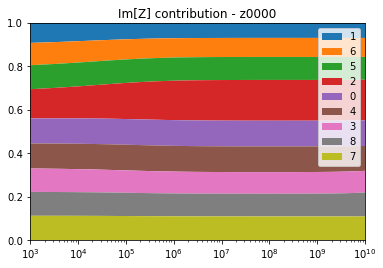

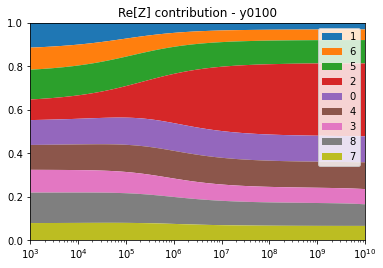

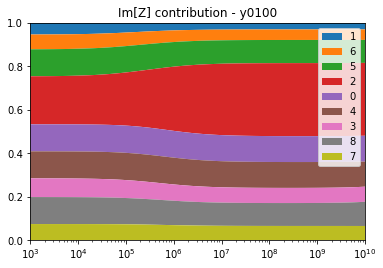

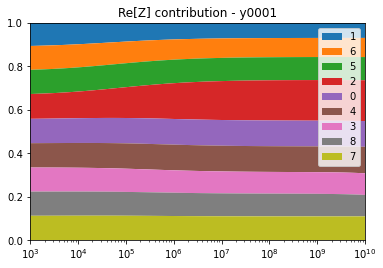

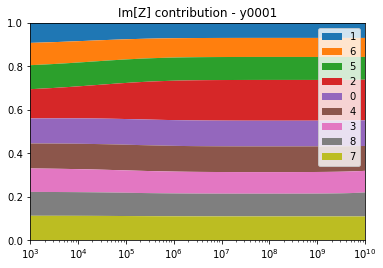

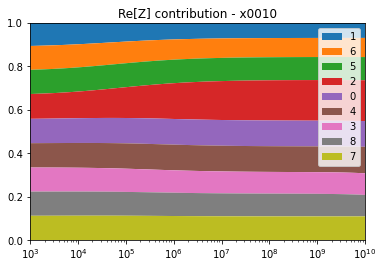

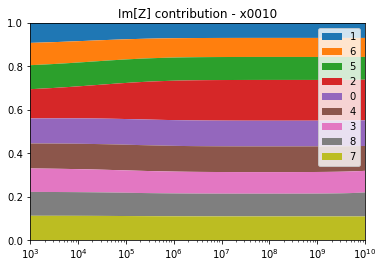

In [17]:
for i, element in enumerate(elements):
    element.tag = str(i)

model = Model(elements)
    
generate_contribution_plots(model)

It is obviously also possible to simply plot the total impedance and wake of the model with the function `plot_total_impedance_and_wake`. Though in our case here, we did not compute the wake of the resistive walls, so only the impedance will be plotted.

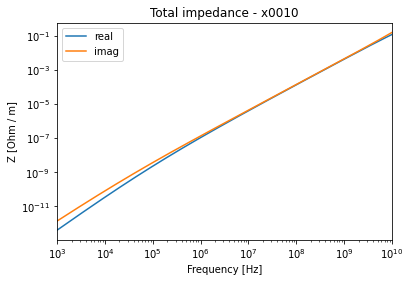

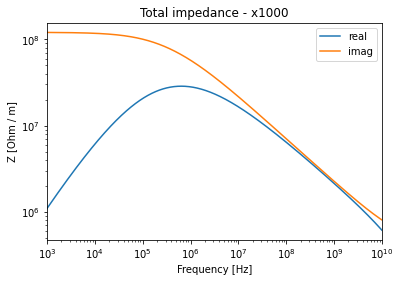

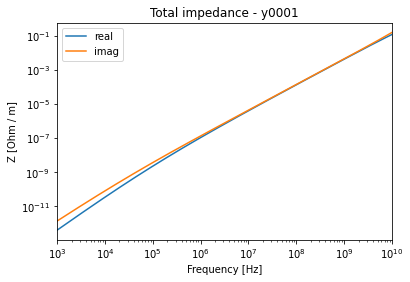

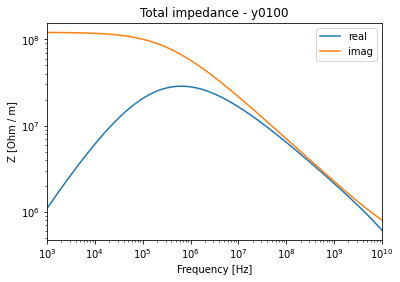

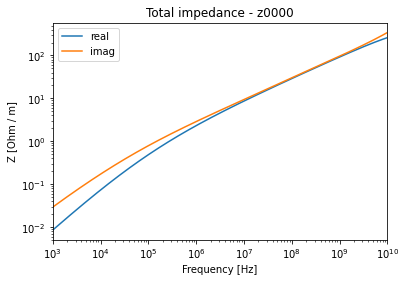

In [18]:
plot_total_impedance_and_wake(model)